<div style='text-align: center;'>
<img src="images/math60082-banner.png" alt="image" width="80%" height="auto">
</div>

# Lab Class - Week 10

## Department of Mathematics

Last time we demonstrated the Crank-Nicolson finite difference method applied to European options
- We showed how accurate it can be,
- How to apply it different problems,
- This time we cover how to adapt finite difference methods to early exercise options.

## American Options


A reminder that American option allow for early exercise, and we must allow the holder of the option to make the optimal decision to exercise early, but without perfect foresight (only using information up to and including the current time $t$). 

Consider the case of an American put option writing on a standard asset $S$ trading in the market. According to standard theory, we can find the solution to the problem by solving 
$$
\frac{\partial P}{\partial t} + \frac12\sigma^2S^2\frac{\partial^2 P}{\partial S^2} + rS\frac{\partial P}{\partial S} - rP \leq 0
\tag{10.1}
$$
$$
P(S,t) \geq X-S
\tag{10.2}
$$
with
$$
P(S,T) = \max(X-S,0),
\tag{10.3}
$$
and the optimal solution will satisfy either the equaility in (10.1) or (10.2), whichever gives the larger result.

Now when using the explicit finite difference method, we have the equation for the value of $P_j^i$ at a grid point
$$
P_j^i = \frac{1}{1+r\Delta t}(AP_{j+1}^{i+1} + BP_{j}^{i+1}+ CP_{j-1}^{i+1})
$$
which satisifies the equality of (10.1). So to get the optimal solution for an American put option, we simple choose the maximum between (10.1) and (10.2), or
$$
P_j^i = \max\left[\frac{1}{1+r\Delta t}(AP_{j+1}^{i+1} + BP_{j}^{i+1}+ CP_{j-1}^{i+1})~ ,~ X - S_j \right] .
$$


In [1]:
# To get started import some libraries
import numpy as np
import scipy
import matplotlib.pyplot as plt

Coding this is up is pretty easy, we just add the maximum condition on one line of code to get the American put option value!

In [2]:
def AmericanPut_FD( X, T, r, sigma, Su_factor, iMax, jMax ):
    # Fix the value of S on the upper boundary,
    # then calculate the step sizes.
    Su = Su_factor * X
    
    dS = Su / jMax
    dt = T / iMax

    # Calculate the values of t_i and S_j
    t = np.array([i*dt for i in range(iMax+1)])
    S = np.array([j*dS for j in range(jMax+1)])

    # Set up storage for the results and intermediates
    vNew = np.zeros(jMax+1)
    vOld = np.zeros(jMax+1)
        
    # first enter the value of the option at expiry
    for j in range(jMax+1):
        vOld[j] = max( X - S[j] , 0.)
        
    # next loop back through time
    for i in range(iMax-1,-1,-1):
        # apply boundary condition at S=0
        vNew[0] = X
        for j in range(1,jMax):
            # input explicit finite difference formula
            A = 0.5*sigma*sigma*j*j*dt + 0.5*r*j*dt
            B = 1.0 - sigma*sigma*j*j*dt
            C = 0.5*sigma*sigma*j*j*dt - 0.5*r*j*dt
            # use vNew[j] for V_j^i and vOld[j] for V_j^{i+1}
            vNew[j] = max( (A*vOld[j+1] + B*vOld[j] + C*vOld[j-1]) / ( 1 + r*dt) , X - S[j] )
        # apply boundary condition at S=S_U
        vNew[jMax] = 0.0
        
        # set old values equal to new ones
        # MAKE SURE THIS IS A DEEP COPY!
        vOld = np.copy(vNew)
    
    return S,vNew

First, we set parameters for the problem.

In [3]:
# Parameters of the contract
X = 10 
T = 1.0

# Market parameters
r = 0.05
sigma = 0.4

# Grid parameters
Su_factor = 5.0
iMax = 1000
jMax = 50

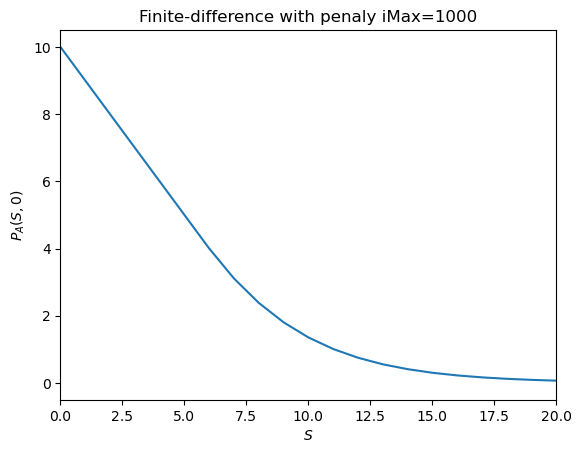

In [4]:
S,vNew = AmericanPut_FD( X, T, r, sigma, Su_factor, iMax, jMax )

# check a plot to see what it looks like
plt.xlim(0, 2.0 * X)
plt.plot(S,vNew)

plt.xlabel( "$S$" )
plt.ylabel( "$P_A(S,0)$" )
plt.title( f"Finite-difference with penaly iMax={iMax}" )
plt.show()

On the output, we should be able to see the resulting solution satisfies $P\geq X-S$. 

# Tasks

- Consider the parameters $X=10$, $T=1$, $r=0.05$ and $\sigma=0.4$.
- Run the American option for different value of $iMax$ and $jMax$, is this method stable for all values of $iMax$?
- Using the calculated value at $S_0=X$, a sufficiently large $S^U$, and a stable value of $iMax$, verify that the convergence rate is $O((\Delta S)^2)$.
- Use interpolation to get the value of the option with $S_0=9.735$, is the convergence rate still $O((\Delta S)^2)$?
- Check that the converged value matches with the result on my website:

[American Option Solver](https://personalpages.manchester.ac.uk/staff/paul.johnson-2/pages/americanCalculator.html)

# Penalty Method


Here we aim to solve the classic American put option problem using the so-called penalty method. 
The penalty method works by solving a slightly different problem, which can be shown to converge to the true solution. The alternative problem we solve combines the inequalities in (10.1) and (10.2) to give
$$
\frac{\partial P}{\partial t} + \frac12\sigma^2S^2\frac{\partial^2 P}{\partial S^2} + rS\frac{\partial P}{\partial S} - rP + \rho\max((X - S) - P , 0 ) = 0
\tag{10.4}
$$
so that in the limit as $\rho \rightarrow \infty$, the value function $P$ satisfies
$$
P(S,t) \geq X-S.
$$
Note that (10.4) is no longer an inequality, so it can be solved directly using a matrix solver. 

However, given a Crank-Nicolson scheme, we won't know if the term $\rho\max((X - S) - P , 0 )$ is zero or has some value until we have solved to find $P$, so some iteration is required. Luckily the number of iterations required to reach a full solution tends to be very small (typically of the order 10 or less).

The method as written here looks confusing, but once written in code it is relatively trivial to adapt to new problems. 
The algorithm works as follows:
- Write down a standard finite difference scheme for the original PDE (including the boundary conditions)
- Take a guess at the solution $v_j^{i,q}$ at the current time step, where $v_j^{i,q}$ is the $q$th guess.
- If $v_j^{i,q} < X - S_j$ adjust the original finite difference approximation to
$$
\hat b_j = b_j - \rho
$$
$$
\hat d_j = d_j - \rho ( X - S_j )
$$ 
- Solve new system with a Thomas algorithm to find $v_j^{i,q+1}$.
- Check for convergence in $||\boldsymbol{v}^{i,q} - \boldsymbol{v}^{i,q+1}||$.

In order to guarantee that our solution is accurate to the level `tol`, we can choose 
$$
\rho = \frac{1}{\mbox{\texttt{tol}}}. 
$$


Now we create a function to return the value of American put using this algorithm. We need additional parameters for the numerical variables $\rho$, `tol` and a maximum nunber of iterations to allow `maxiter`.

In [5]:
# Penalty method solver
def AmericanPut_CN( X, T, r, sigma, Su_factor, iMax, jMax, rho, tol, max_iter, printProgress=True ):
    # Fix the value of S on the upper boundary,
    # then calculate the step sizes.
    Su = Su_factor * X
    
    dS = Su / jMax
    dt = T / iMax

    # Calculate the values of t_i and S_j
    t = np.array([i*dt for i in range(iMax+1)])
    S = np.array([j*dS for j in range(jMax+1)])

    # Set up storage for the results and intermediates
    vNew = np.zeros(jMax+1)
    vOld = np.zeros(jMax+1)

    # Get the value of the option at expiry 
    for j in range(jMax+1):
        vOld[j] = max( X - S[j] , 0.0 )

    # Set up ingredients needed by SciPy's solve_banded()
    # See the solutions to the lab for Week 9 for details.
    A_banded = np.zeros(shape=(3,jMax+1))
    u=1
    l=1
    l_and_u = (l, u)

    # Compute the entries in the tridiagonal matrix, begining
    # with the top row.
    # b_0 V_0 + c_0 V_1 = d_0
    A_banded[1][0] = 1.0 # b_0
    A_banded[0][1] = 0.0 # c_0
    
    # Populate middle rows
    for j in range(1,jMax):
        # a_j V_j-1 + b_j V_j + c_i V_j+1 = d_i
        A_banded[2][j-1] = 0.25*(sigma*sigma*j*j - r*j) # a_j
        A_banded[1][j] = -1./dt - 0.5*sigma*sigma*j*j - 0.5*r # b_j
        A_banded[0][j+1] = 0.25*(sigma*sigma*j*j + r*j) # c_j
        
    # Set entries from the bottom row.
    # a_jMax V_jMax-1 + b_jMax V_jMax = d_jMax
    A_banded[2][jMax-1] = 0.0 # a_jMax 
    A_banded[1][jMax] = 1.0 # b_jMax
    
    # Create a copy of A_banded that we can adjust to incorporate the penalty
    A_banded_w_penalty = np.copy(A_banded)

    # Step backward through time
    for i in range(iMax-1,-1,-1):
        # Create a vector for multiplication
        d = np.zeros(jMax+1)
        
        # Adjust boundary condition to be P=X because it is American
        d[0] = X
        for j in range(1,jMax):
            aa = 0.25*(sigma*sigma*j*j - r*j) # a_j
            bb = 1./dt - 0.5*sigma*sigma*j*j - 0.5*r # b_j + 2./dt
            cc = 0.25*(sigma*sigma*j*j + r*j) # c_j
            d[j] = - aa*vOld[j-1] - bb*vOld[j] - cc*vOld[j+1]
            
        d[jMax] = 0.0
        
        # create a new copy of d, that can be adjusted depending on the penalty
        d_w_penalty = np.copy(d)
            
        # Penalty loop to solve for vNew
        iter_num = 0
        converged = False # at least for now
        while (iter_num < max_iter) and not converged:
            # Determine which rows to adjust with a penalty
            for j in range(1,jMax):
                # Check whether P<X-S and apply the penalty where this is true
                if vNew[j] < X - S[j]:
                    # b'_j = b_j - rho
                    A_banded_w_penalty[1][j] = A_banded[1][j] - rho
                    
                    # d'_j = d_j - rho*(X-S)
                    d_w_penalty[j] = d[j] - rho*(X - S[j])
                    
                # Otherwise use the original values of A_banded and d
                else:
                    # b'_j = b_j
                    A_banded_w_penalty[1][j] = A_banded[1][j]
                    
                    # d'_j = d_j 
                    d_w_penalty[j] = d[j]
                    

            # Use banded solver solver to solve problem
            #    A' v^{i,q+1} = d'
            # here y ~ v_j^{i,q+1}
            y = scipy.linalg.solve_banded(l_and_u, A_banded_w_penalty, d_w_penalty)
            
            # Compute the change in value from the previous iteration
            # e = v_j^{i,q+1} - v_j^{i,q} 
            e = y-vNew
            
            # Update the value of vNew
            vNew = y
            
            # Check the norm against the tolerance for convergence
            iter_num += 1
            if np.linalg.norm(e,1) < tol:
                converged = True # Prepare to exit the loop
                if printProgress:
                    print( f"Solved at step {i}. Converged after {iter_num} iterations.")

        # When we each this point, we have Solved for vNew and can go on to 
        # the enxt time step, so that vOld should receive the values stored in vNew.
        vOld = np.copy(vNew)
        
    return S, vNew

In [6]:
# Adjust grid parameters: we don't need such a large iMax for Crank-Nicolson
iMax = 50
jMax = 50

# Parameters of the penalty method
rho = 1.0e8
tol = 1.0e-8
maxIter = 50

Solved at step 49. Converged after 2 iterations.
Solved at step 48. Converged after 3 iterations.
Solved at step 47. Converged after 2 iterations.
Solved at step 46. Converged after 2 iterations.
Solved at step 45. Converged after 2 iterations.
Solved at step 44. Converged after 3 iterations.
Solved at step 43. Converged after 2 iterations.
Solved at step 42. Converged after 2 iterations.
Solved at step 41. Converged after 2 iterations.
Solved at step 40. Converged after 2 iterations.
Solved at step 39. Converged after 2 iterations.
Solved at step 38. Converged after 2 iterations.
Solved at step 37. Converged after 2 iterations.
Solved at step 36. Converged after 2 iterations.
Solved at step 35. Converged after 2 iterations.
Solved at step 34. Converged after 2 iterations.
Solved at step 33. Converged after 2 iterations.
Solved at step 32. Converged after 2 iterations.
Solved at step 31. Converged after 2 iterations.
Solved at step 30. Converged after 2 iterations.
Solved at step 29. C

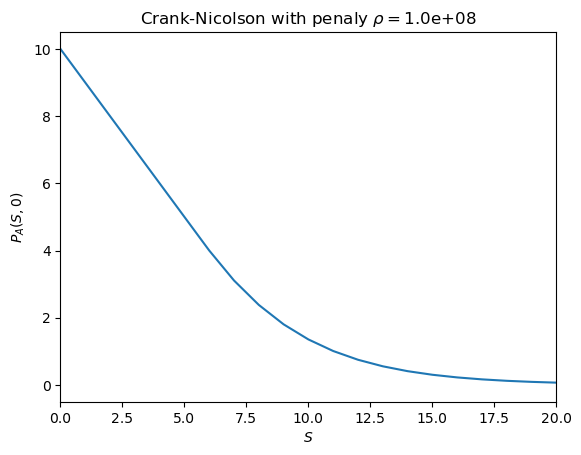

In [7]:
S_CN, V_CN = AmericanPut_CN( X, T, r, sigma, Su_factor, iMax, jMax, rho, tol, maxIter )

# check a plot to see what it looks like
plt.xlim(0,20)
plt.plot(S_CN, V_CN)
plt.xlabel( "$S$" )
plt.ylabel( "$P_A(S,0)$" )
plt.title( f"Crank-Nicolson with penaly $\\rho = ${rho:.1e}" )
plt.show()

Here we see that the method only takes one or two iterations to converge, and the plot looks very similar to before.

# Tasks

- Using interpolation to calculate the value at $S_0=X$ and with $S^U=50$, and different values of `iMax` and `jMax`, verify the convergence rate of this algorithm is $O((\Delta t)^2,(\Delta S)^2)$.
- Try using Richardson extrapolation to improve your calculated results.
- Using interpolation to calculate the value at $S_0=9.735$, is the convergence rate still $O((\Delta t)^2,(\Delta S)^2)$?
- What is the efficincy of this method compared to the previous one? Say we want 6 digits of accuracy for the option value, which method can calculate it quicker? Can you use `numba` to compile and speed up your code where possible?
- Update this code to include dividends, and make it solve for a call option. 


#### Acceleration with a Thomas solver

As in Week 9, it is possible to accelerate the code using `numba`, but we must first replace the call to 
`scipy.linalg.solve_banded()` with our own code. Here, as previously, I use a Thomas slover and will store the diagonals of $A$ in a `(jMax+1)` $\times 3$ array `A_diags` where:
* `A_diags[j,0]` $= a_j$ (and hence is undefined for $j=0$)
* `A_diags[j,1]` $= b_j$ (and hence is defined for $0 \leq j \leq$ `jMax`)
* `A_diags[j,2]` $= c_j$ (and hence is undefined for $j =$ `jMax`)

In [8]:
from numba import njit

# Penalty method solver
@njit
def AmericanPut_CN2( X, T, r, sigma, Su_factor, iMax, jMax, rho, tol, max_iter ):
    # Fix the value of S on the upper boundary,
    # then calculate the step sizes.
    Su = Su_factor * X
    
    dS = Su / jMax
    dt = T / iMax

    # Calculate the values of t_i and S_j
    t = np.array([i*dt for i in range(iMax+1)])
    S = np.array([j*dS for j in range(jMax+1)])

    # Set up storage for the results and intermediates
    vNew = np.zeros(jMax+1)
    vOld = np.zeros(jMax+1)
    
    # Get the value of the option at expiry 
    for j in range(jMax+1):
        vOld[j] = max( X - S[j] , 0.0 )

    # Set up storage for the tri-diagonal matrix A
    # as described above.
    A_diags = np.zeros(shape=(jMax+1,3)) 

    # Enforce the boundary condition at S=0
    # b_0 V_0 + c_0 V_1 = d_0
    A_diags[0,1] = 1.0 # b_0 = 1
    A_diags[0,2] = 0.0 # c_0 = 0
    
    # Set a[j], b[j] and c[j] for the middle rows
    for j in range(1,jMax):
        # a_j V_j-1 + b_j V_j + c_i V_j+1 = d_i
        A_diags[j,0] = 0.25*(sigma*sigma*j*j - r*j) # a_j
        A_diags[j,1] = -1.0/dt - 0.5*sigma*sigma*j*j - 0.5*r # b_j
        A_diags[j,2] = 0.25*(sigma*sigma*j*j + r*j) # c_j
        
    # Enforce the boundary condition at S = Su
    # a_jMax V_jMax-1 + b_jMax V_jMax = d_jMax
    A_diags[jMax,0] = 0.0 # a_jMax = 0
    A_diags[jMax,1] = 1.0 # b_jMax = 1
    
    # Allocate storage for the righthand side of the equation Av = d
    d = np.zeros(jMax+1) 
    
    # Step backward through time
    for i in range(iMax-1,-1,-1):
        # Evaluate the righthand side
        d[0] = X # Adjust boundary condition to be P=X because this is an American put
        for j in range(1,jMax):
            aa = A_diags[j,0] # a_j
            bb = A_diags[j,1] + 2.0/dt # b_j + 2/dt
            cc = A_diags[j,2] # c_j
            d[j] = - aa*vOld[j-1] - bb*vOld[j] - cc*vOld[j+1]
            
        d[jMax] = 0.0

        # Create copies of A_diags and d that we can adjust to incorporate the penalty
        A_diags_w_penalty = np.copy(A_diags)
        d_w_penalty = np.copy(d)
            
        # Penalty loop to solve for vNew
        iter_num = 0
        converged = False # at least for now
        while (iter_num < max_iter) and not converged:
            # Determine which rows to adjust with a penalty
            for j in range(1,jMax):
                # Check whether P < X-S and apply the penalty whenever this is true
                if vNew[j] < X - S[j]:
                    A_diags_w_penalty[j,1] = A_diags[j,1] - rho # b'_j = b_j - rho
                    d_w_penalty[j] = d[j] - rho*(X - S[j]) # d'_j = d_j - rho*(X-S)
                    
                # Otherwise use the original values of A_diags and d
                else:
                    A_diags_w_penalty[j,1] = A_diags[j,1] # b'_j = b_j
                    d_w_penalty[j] = d[j] # d'_j = d_j 
                    
            ########################################################################
            # Solve the tridiagonal system using a Thomas solver:
            # https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
            ########################################################################
            cPrime = np.zeros(jMax)
            dPrime = np.zeros(jMax)

            cPrime[0] = A_diags_w_penalty[0,2] / A_diags_w_penalty[0,1] # c_0 / b_0
            dPrime[0] = d_w_penalty[0] / A_diags_w_penalty[0,1] # d_0 / b_0
            for j in range(1,jMax):
                cp_denom = A_diags_w_penalty[j,1] - A_diags_w_penalty[j,0]*cPrime[j-1] 
                cPrime[j] = A_diags_w_penalty[j,2] / cp_denom # c_j / (b_j - a_j*c'_{j-1})
                
                dp_numerator = d_w_penalty[j] - A_diags_w_penalty[j,0]*dPrime[j-1] # d_j - a_j*d'_{j-1}
                dp_denom = A_diags_w_penalty[j,1] - A_diags_w_penalty[j,0]*cPrime[j-1] # b_j - a_j*c'_{j-1}
                dPrime[j] = dp_numerator / dp_denom
        
            # Get the last entry in dPrime
            dp_numerator = d_w_penalty[jMax] - A_diags_w_penalty[jMax,0]*dPrime[jMax-1] 
            dp_denom = A_diags_w_penalty[jMax,1] - A_diags_w_penalty[jMax,0]*cPrime[jMax-1]
            dPrime[jMax] = dp_numerator / dp_denom
        
            # Now obtain the result via back-substitution.
            y = np.zeros(jMax+1) # Holds approximate solutions during iterations

            y[jMax] = dPrime[jMax]
            for j in range(jMax-1, -1, -1):
                y[j] = dPrime[j] - cPrime[j]*y[j+1]
                
            ###########################################################

            # Compute the change in value from the previous iteration
            # e = v_j^{i,q+1} - v_j^{i,q} 
            e = y-vNew
            
            # Copy y into vNew, taking care to make a deep copy
            vNew = np.copy(y)
            
            # Check the norm against the tolerance for convergence
            iter_num += 1
            if np.linalg.norm(e,1) < tol:
                converged = True # Prepare to exit the loop
                
        # When we each this point, we have solved for vNew and can go on to 
        # the enxt time step, so that vOld should receive the values stored in vNew.
        vOld = np.copy(vNew)
        
    return S, vNew

# Test this version against the other Crank-Nicolson implementation
S_CN2, V_CN2 = AmericanPut_CN2(X, T, r, sigma, Su_factor, iMax, jMax, rho, tol, maxIter)
V_CN - V_CN2 # These should all be close to zero

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.88178420e-16, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.22044605e-15, 2.66453526e-15, 1.33226763e-15, 8.88178420e-16,
       8.88178420e-16, 8.88178420e-16, 9.99200722e-16, 7.77156117e-16,
       6.10622664e-16, 4.99600361e-16, 4.57966998e-16, 3.60822483e-16,
       2.35922393e-16, 1.66533454e-16, 1.17961196e-16, 9.71445147e-17,
       7.28583860e-17, 5.20417043e-17, 3.98986399e-17, 3.12250226e-17,
       2.34187669e-17, 1.82145965e-17, 1.47451495e-17, 1.17093835e-17,
       8.67361738e-18, 6.72205347e-18, 4.98732999e-18, 3.68628739e-18,
       3.03576608e-18, 2.49366500e-18, 1.84314369e-18, 1.35525272e-18,
       1.08420217e-18, 8.13151629e-19, 6.50521303e-19, 4.60785923e-19,
       3.25260652e-19, 2.43945489e-19, 1.89735380e-19, 1.42301535e-19,
       9.48676901e-20, 4.74338450e-20, 0.00000000e+00])

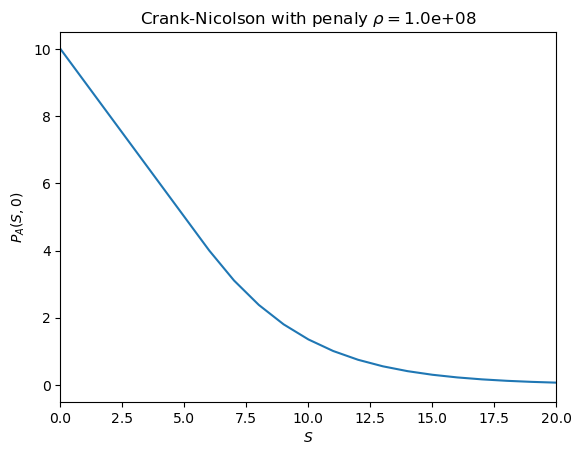

In [9]:
# check a plot to see what it looks like
plt.xlim(0,20)
plt.plot(S_CN2, V_CN2)
plt.xlabel( "$S$" )
plt.ylabel( "$P_A(S,0)$" )
plt.title( f"Crank-Nicolson with penaly $\\rho = ${rho:.1e}" )
plt.show()

In [11]:
# Do some timing experiments
from timeit import timeit

nReps = 100
CN_script = "AmericanPut_CN(X, T, r, sigma, Su_factor, iMax, jMax, rho, tol, maxIter, False)"
CN_time = timeit( CN_script, number=nReps, globals=globals() )
print( f"{nReps} repetitions of AmericanPut_CN() took {CN_time:.2f} seconds." )

CN2_script = "AmericanPut_CN2(X, T, r, sigma, Su_factor, iMax, jMax, rho, tol, maxIter)"
CN2_time = timeit( CN2_script, number=nReps, globals=globals() )
print( f"{nReps} repetitions of AmericanPut_CN2() took {CN2_time:.4f} seconds." )

ratio = CN_time/CN2_time
print( f"That's a speedup by a factor of around {ratio:.1f}." )

100 repetitions of AmericanPut_CN() took 0.51 seconds.
100 repetitions of AmericanPut_CN2() took 0.0106 seconds.
That's a speedup by a factor of around 48.4.
